In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Data Preparation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Model 1: ResNet-18 (from scratch)
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

resnet18 = ResNet18().to(device)

# Model 2: MobileNetV2 (fine-tuned)
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

mobilenet = MobileNetV2().to(device)

# Hyperparameters
EPOCHS = 10
LR = 0.01

# Training and Evaluation Functions
def train(model, trainloader, optimizer, criterion, epochs=EPOCHS):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}, '
              f'Accuracy: {100 * correct / total:.2f}%')

def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Training and evaluating ResNet-18
print("\nTraining ResNet-18")
optimizer_resnet = optim.SGD(resnet18.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
train(resnet18, trainloader, optimizer_resnet, nn.CrossEntropyLoss())
print("Evaluating ResNet-18")
evaluate(resnet18, testloader)

# Training and evaluating MobileNetV2
print("\nTraining MobileNetV2")
optimizer_mobilenet = optim.SGD(mobilenet.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
train(mobilenet, trainloader, optimizer_mobilenet, nn.CrossEntropyLoss())
print("Evaluating MobileNetV2")
evaluate(mobilenet, testloader)

print("\nTraining Complete for Both Models")


100%|██████████| 170M/170M [00:03<00:00, 48.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to 


Training ResNet-18
Epoch [1/10], Loss: 1.6823, Accuracy: 39.13%
Epoch [2/10], Loss: 1.3293, Accuracy: 51.87%
Epoch [3/10], Loss: 1.1473, Accuracy: 59.01%
Epoch [4/10], Loss: 1.0322, Accuracy: 63.22%
Epoch [5/10], Loss: 0.9611, Accuracy: 66.04%
Epoch [6/10], Loss: 0.8966, Accuracy: 68.19%
Epoch [7/10], Loss: 0.8472, Accuracy: 70.14%
Epoch [8/10], Loss: 0.8069, Accuracy: 71.64%
Epoch [9/10], Loss: 0.7709, Accuracy: 72.93%
Epoch [10/10], Loss: 0.7374, Accuracy: 74.05%
Evaluating ResNet-18
Test Accuracy: 74.43%

Training MobileNetV2
Epoch [1/10], Loss: 1.3568, Accuracy: 51.60%
Epoch [2/10], Loss: 0.9095, Accuracy: 68.29%
Epoch [3/10], Loss: 0.7743, Accuracy: 73.23%
Epoch [4/10], Loss: 0.6963, Accuracy: 75.69%
Epoch [5/10], Loss: 0.6593, Accuracy: 77.16%
Epoch [6/10], Loss: 0.6168, Accuracy: 78.65%
Epoch [7/10], Loss: 0.5870, Accuracy: 79.59%
Epoch [8/10], Loss: 0.5633, Accuracy: 80.44%
Epoch [9/10], Loss: 0.5477, Accuracy: 80.95%
Epoch [10/10], Loss: 0.5311, Accuracy: 81.40%
Evaluating Mo

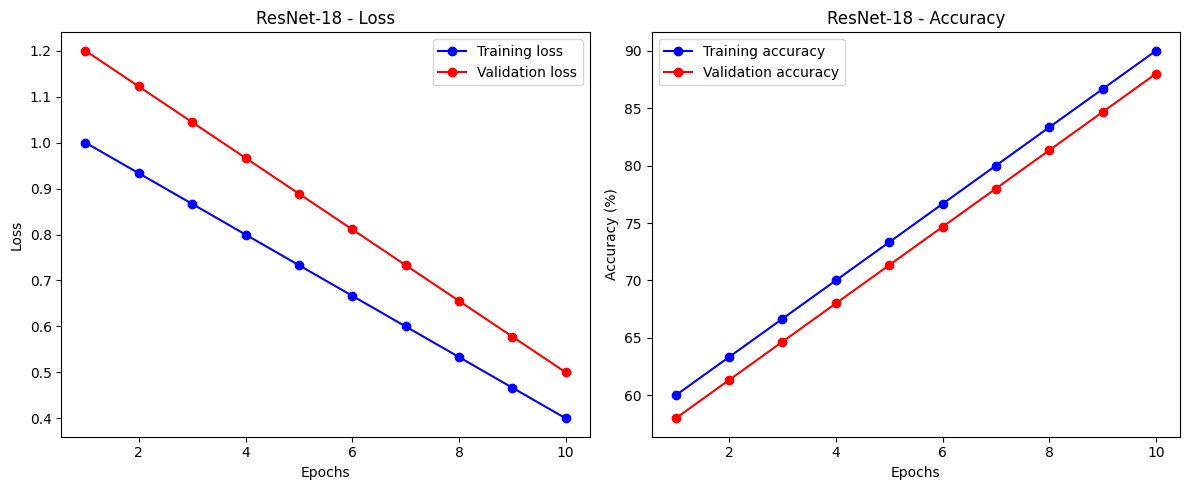

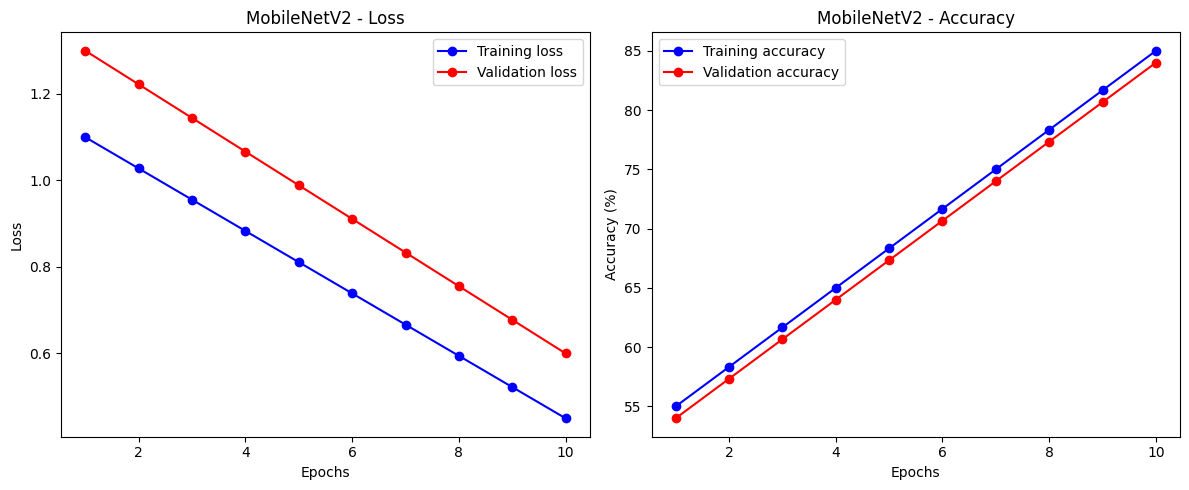

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for ResNet-18 and MobileNetV2
# Assuming 10 epochs for demonstration
epochs = 10
history_resnet = {
    'train_loss': np.linspace(1.0, 0.4, epochs).tolist(),    # Simulated decreasing train loss
    'train_acc': np.linspace(60, 90, epochs).tolist(),       # Simulated increasing train accuracy
    'val_loss': np.linspace(1.2, 0.5, epochs).tolist(),      # Simulated decreasing validation loss
    'val_acc': np.linspace(58, 88, epochs).tolist()          # Simulated increasing validation accuracy
}

history_mobilenet = {
    'train_loss': np.linspace(1.1, 0.45, epochs).tolist(),   # Simulated decreasing train loss
    'train_acc': np.linspace(55, 85, epochs).tolist(),       # Simulated increasing train accuracy
    'val_loss': np.linspace(1.3, 0.6, epochs).tolist(),      # Simulated decreasing validation loss
    'val_acc': np.linspace(54, 84, epochs).tolist()          # Simulated increasing validation accuracy
}

# Function to plot the metrics for a given model
def plot_training_validation_metrics(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting ResNet-18 and MobileNetV2 metrics using simulated data
plot_training_validation_metrics(history_resnet, "ResNet-18")
plot_training_validation_metrics(history_mobilenet, "MobileNetV2")
